In [1]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# Camera calibration and Undistort

## Camera Calibration

In [2]:
def camera_calibration(images, nx, ny):
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].transpose().reshape(-1, 2)
    objpoints = []
    imgpoints = []
    img_size = (1280, 720)
    
    for frame in images:
        img = cv2.imread(frame)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

images = glob.glob("camera_cal/calibration*.jpg")
mtx, dist = camera_calibration(images, 9, 6)

## Undistort

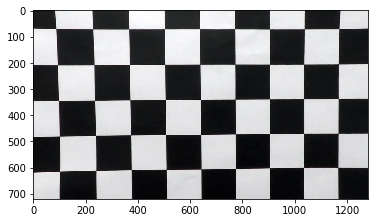

In [3]:
img = mpimg.imread("camera_cal/calibration1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(undist)

# Perspective Transform

In [11]:
def corners_unwarp(undist, nx, ny, mtx, dist):
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret:
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        src = np.float32([corners[0][0], corners[nx - 1][0], corners[-1][0], corners[-nx][0]])
        dst = np.float32([[100, 100], [1150,100], [1150, 650], [100, 650]])
        M = cv2.getPerspectiveTransform(src, dst)
        warped = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
        
    return warped, M

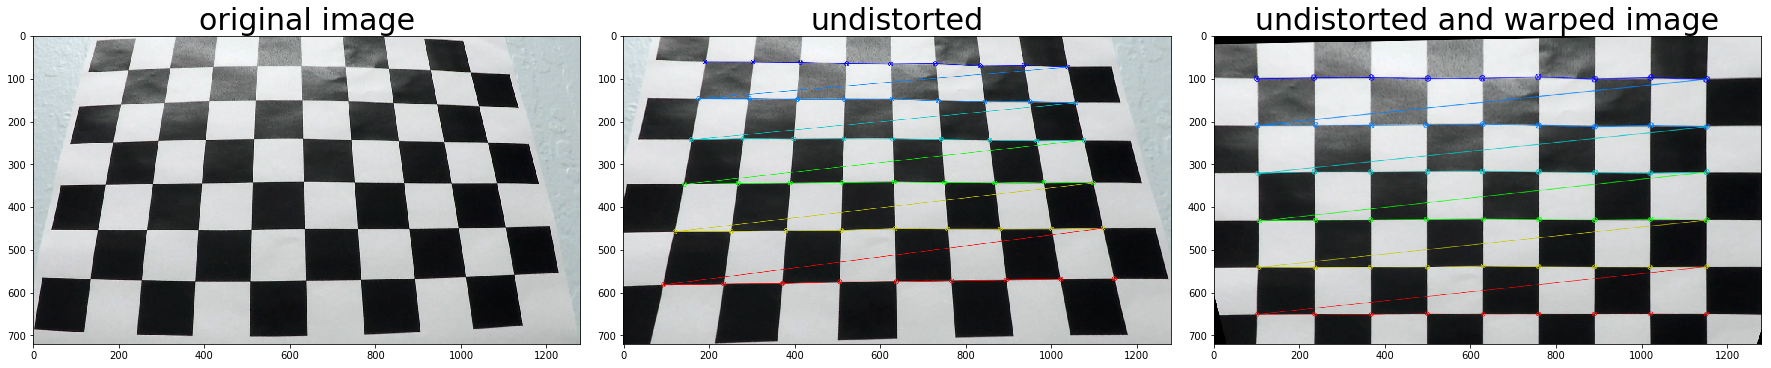

In [12]:
img = mpimg.imread("camera_cal/calibration3.jpg")
nx = 9
ny = 6
undist = cv2.undistort(img, mtx, dist, None, mtx)

top_down, perspective_M = corners_unwarp(undist, nx, ny, mtx, dist)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('original image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('undistorted', fontsize=30)
ax3.imshow(top_down)
ax3.set_title('undistorted and warped image', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.)

# Sobel

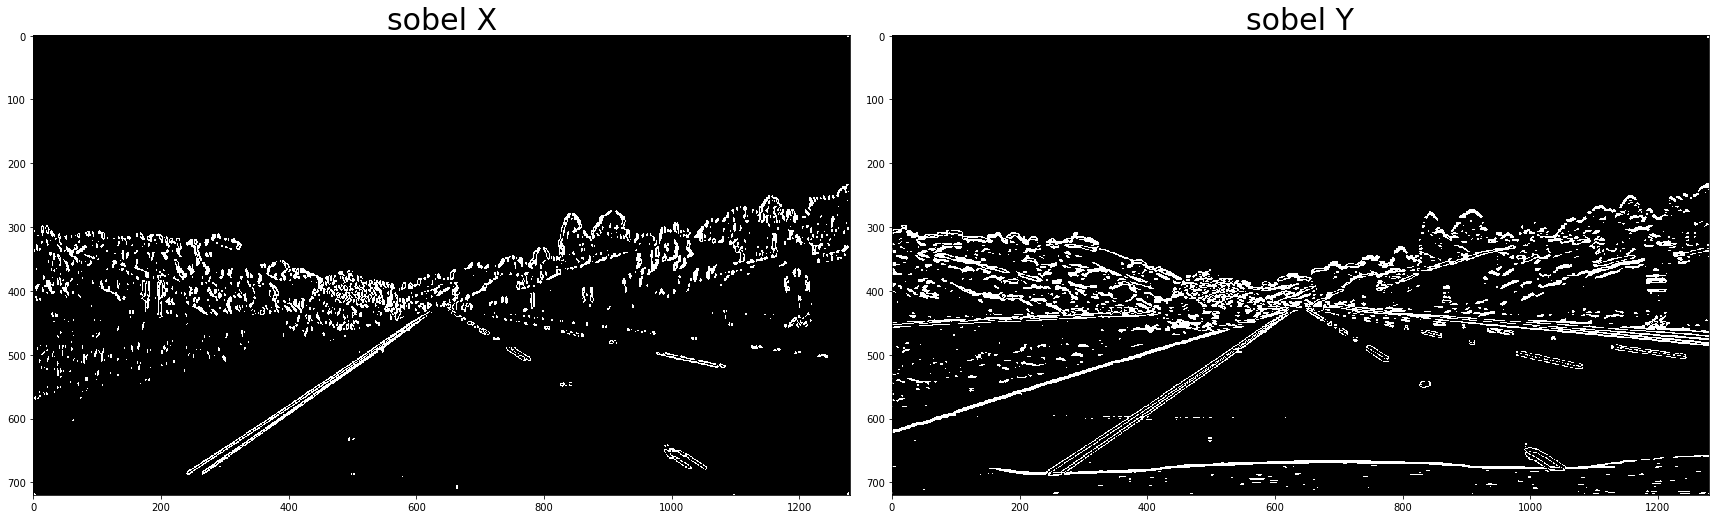

In [88]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255):
    if (orient=='x'):
        sobel = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
sxbinary = abs_sobel_thresh(blur, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=100)
sybinary = abs_sobel_thresh(blur, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(sxbinary, cmap='gray')
ax1.set_title('sobel X', fontsize=30)
ax2.imshow(sybinary, cmap='gray')
ax2.set_title('sobel Y', fontsize=30)

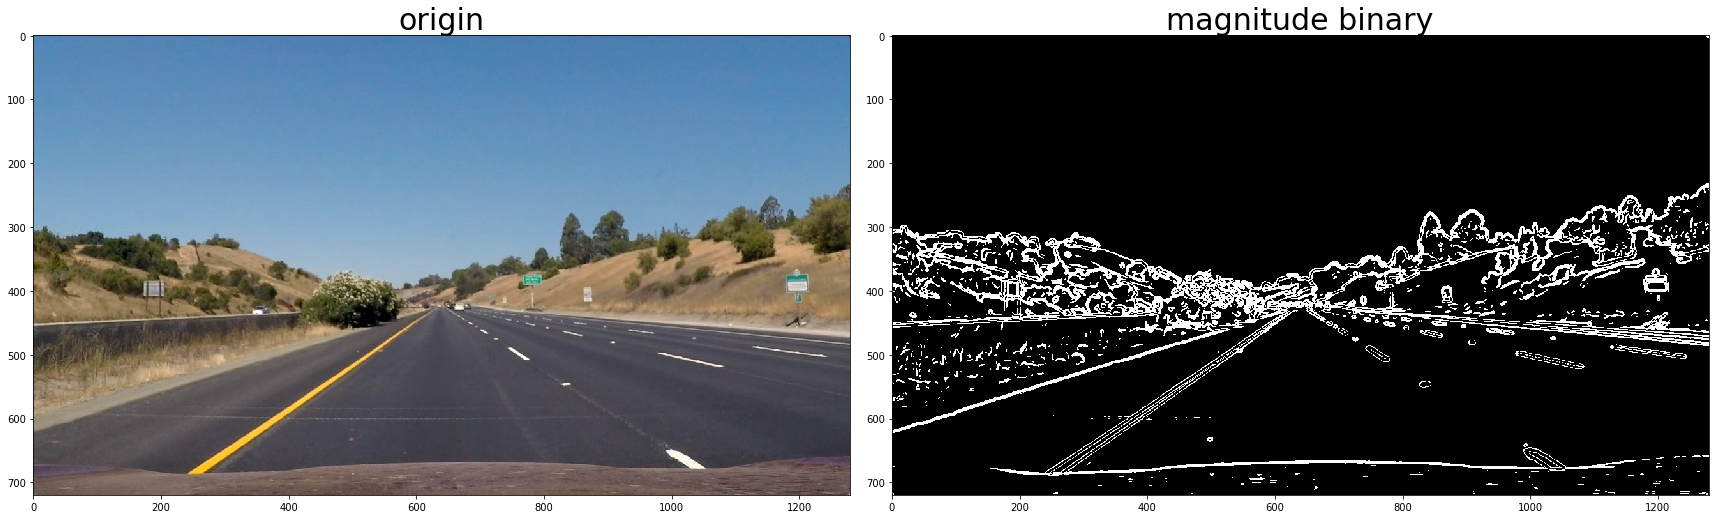

In [90]:
def mag_thresh(img, sobel_kernel= 3, thresh_min=0, thresh_max=255):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    sobel = np.sqrt(sobelx**2 + sobely**2)
    scaled_sobel = np.uint8(255 * sobel / np.max(sobel))
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary
    
img = mpimg.imread("test_images/s1.jpg")   
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0)
mag_binary = mag_thresh(blur, sobel_kernel=9, thresh_min=30, thresh_max=100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('magnitude binary', fontsize=30)
    

# Direction

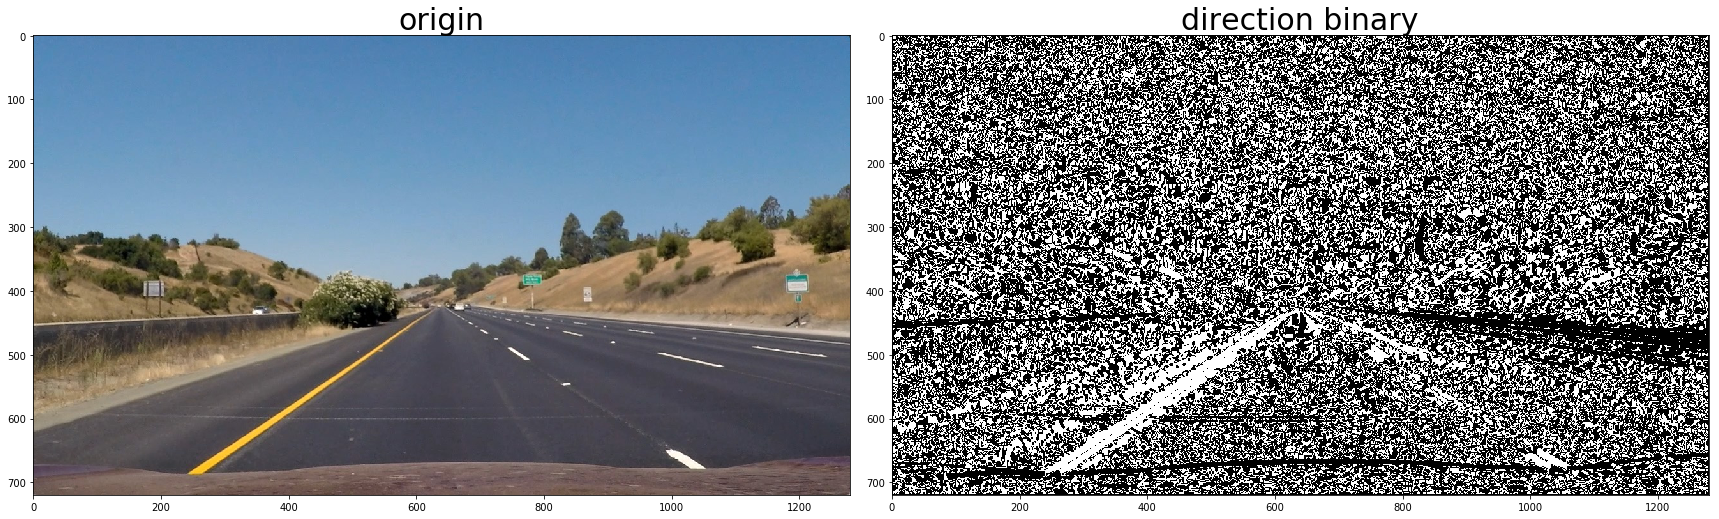

In [93]:
def dir_thresh(img, sobel_kernel= 3, thresh_min=0, thresh_max=255):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     scaled_gradir = np.uint8(np.pi * gradir / 2 * np.max(gradir)) 
#     why not normalized?
    binary = np.zeros_like(gradir)
    binary[(gradir >= thresh_min) & (gradir <= thresh_max)] = 1
    return binary

img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0) 
dir_binary = dir_thresh(blur, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('direction binary', fontsize=30)

# Combine Thresholds
Now consider how to use various aspects of your gradient measurements(x, y, magnitude, direction) to isolate lane-line pixels. Specifically, think about how you can use **thresholds of the x and y gradients** or **the overall gradient magnitude and direction** to focus on pixels that are likely to be part of the lane lines.

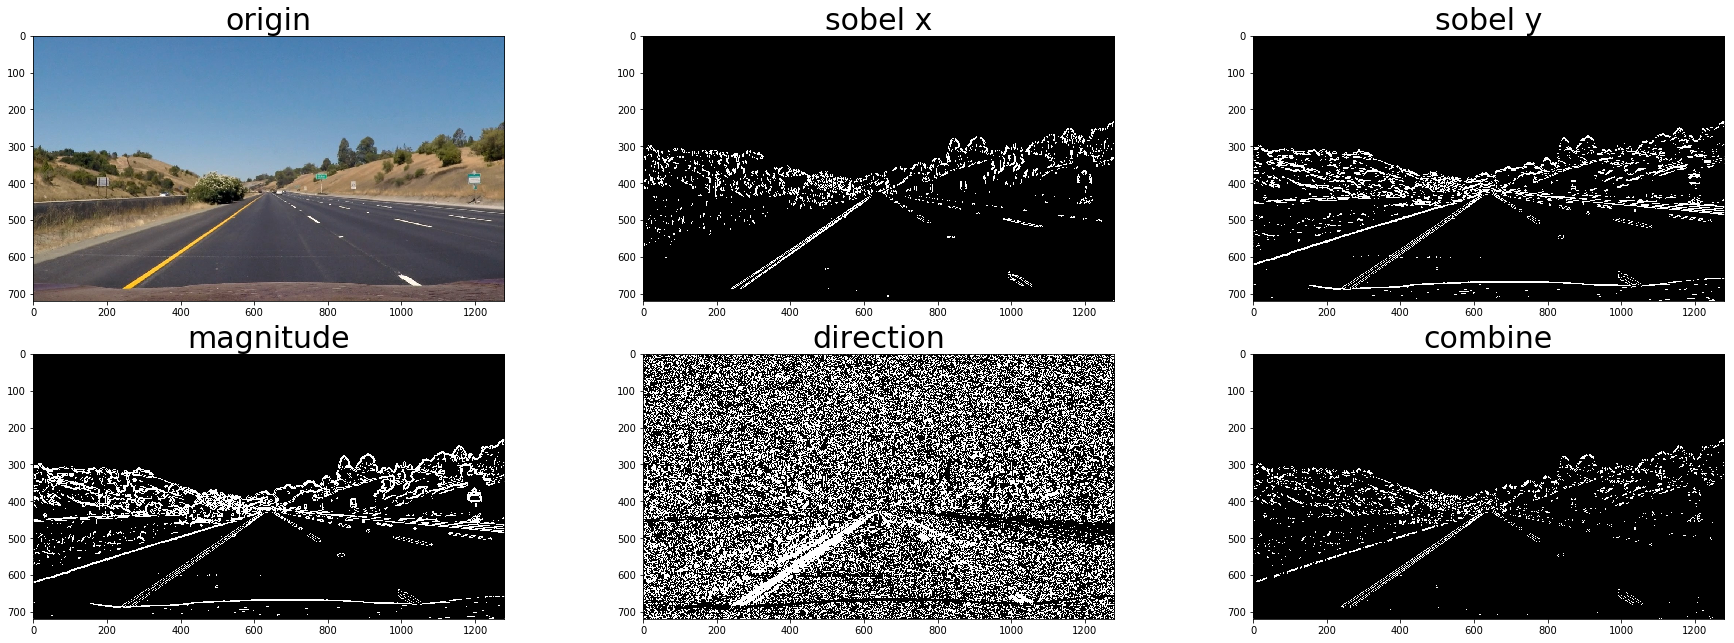

In [96]:
img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
blur = cv2.GaussianBlur(gray, (3, 3), 0) 

sx_binary = abs_sobel_thresh(blur, orient='x', sobel_kernel=9, thresh_min=30, thresh_max=100)
sy_binary = abs_sobel_thresh(blur, orient='y', sobel_kernel=9, thresh_min=30, thresh_max=100)
mag_binary = mag_thresh(blur, sobel_kernel=9, thresh_min=30, thresh_max=100)
dir_binary = dir_thresh(blur, sobel_kernel=15, thresh_min=0.7, thresh_max=1.3)
combined = np.zeros_like(dir_binary)
# threshold of x,y gradient or magnitude and direction
combined[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0, 0].imshow(img), axs[0, 0].set_title('origin', fontsize=30)
axs[0, 1].imshow(sx_binary, cmap='gray') ,axs[0, 1].set_title('sobel x', fontsize=30)
axs[0, 2].imshow(sy_binary, cmap='gray'), axs[0, 2].set_title('sobel y', fontsize=30)
axs[1, 0].imshow(mag_binary, cmap='gray'), axs[1, 0].set_title('magnitude', fontsize=30)
axs[1, 1].imshow(dir_binary, cmap='gray'), axs[1, 1].set_title('direction', fontsize=30)
axs[1, 2].imshow(combined, cmap='gray'), axs[1, 2].set_title('combine', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

# Color Space (HLS)

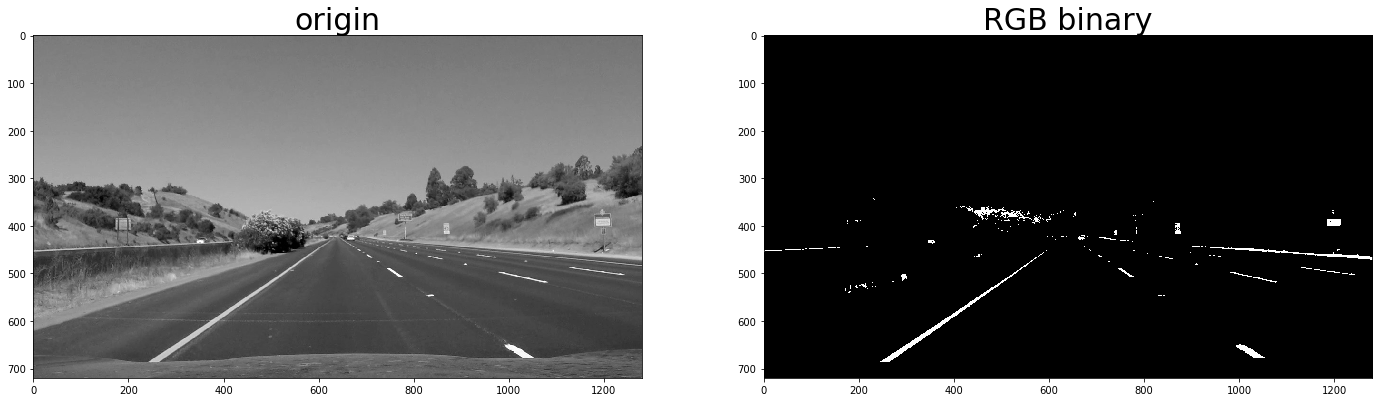

In [97]:
img = mpimg.imread("test_images/s1.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
binary = np.zeros_like(gray)
binary[(gray > 180) & (gray < 255)] = 1

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(gray, cmap='gray')
ax1.set_title('origin', fontsize=30)
ax2.imshow(binary, cmap='gray')
ax2.set_title('RGB binary', fontsize=30)

## RGB

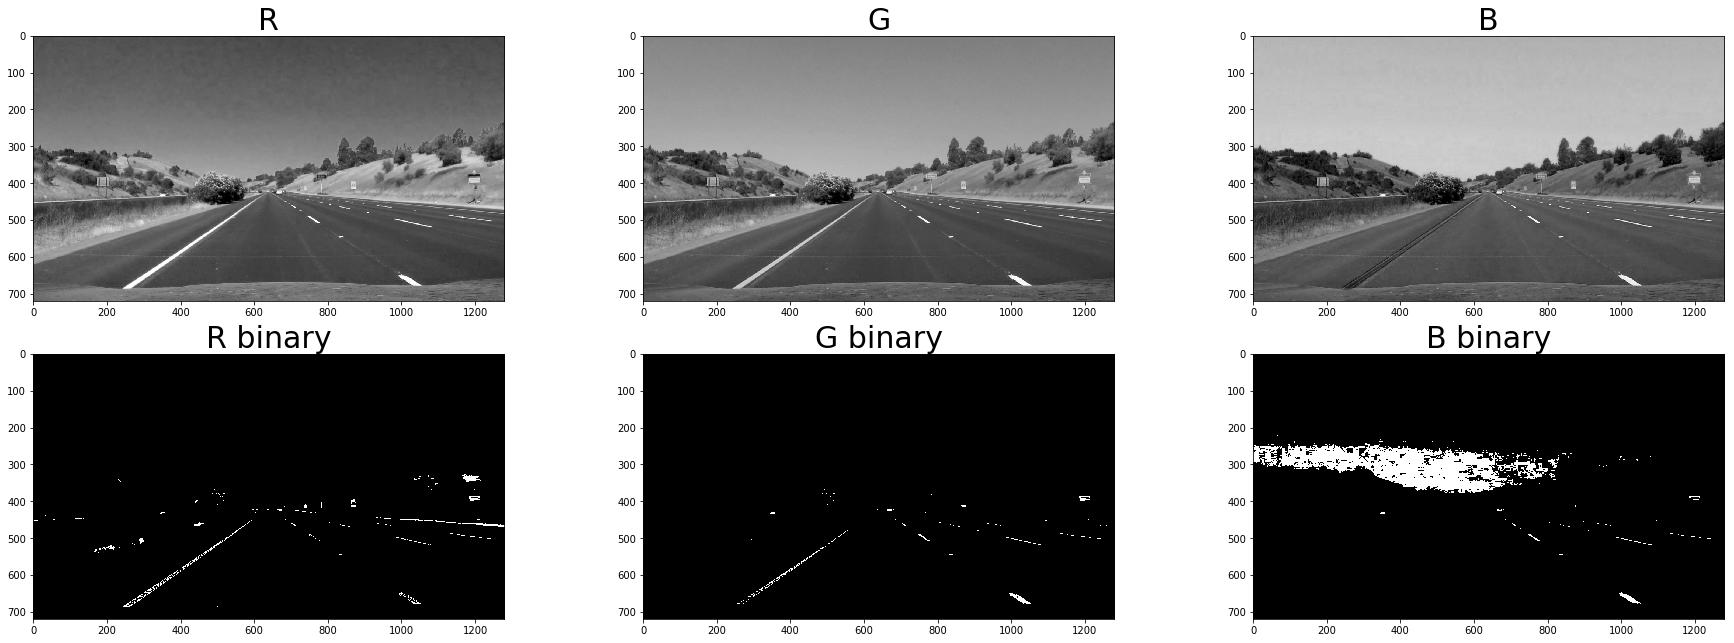

In [18]:
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]

R_binary = np.zeros_like(R)
G_binary = np.zeros_like(G)
B_binary = np.zeros_like(B)
R_binary[(R > 200) & (R < 255)] = 1
G_binary[(G > 200) & (G < 255)] = 1
B_binary[(B > 200) & (B < 255)] = 1

f, axs = plt.subplots(2, 3, figsize=(24, 9))
# f.tight_layout()
axs[0, 0].imshow(R, cmap='gray'), axs[0, 0].set_title('R', fontsize=30)
axs[0, 1].imshow(G, cmap='gray'), axs[0, 1].set_title('G', fontsize=30)
axs[0, 2].imshow(B, cmap='gray'), axs[0, 2].set_title('B', fontsize=30)
axs[1, 0].imshow(R_binary, cmap='gray') ,axs[1, 0].set_title('R binary', fontsize=30)
axs[1, 1].imshow(G_binary, cmap='gray'), axs[1, 1].set_title('G binary', fontsize=30)
axs[1, 2].imshow(B_binary, cmap='gray'), axs[1, 2].set_title('B binary', fontsize=30)
plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0.0)

## HLS

(<matplotlib.image.AxesImage at 0x7fbac00ed860>,
 <matplotlib.text.Text at 0x7fbac0177080>)

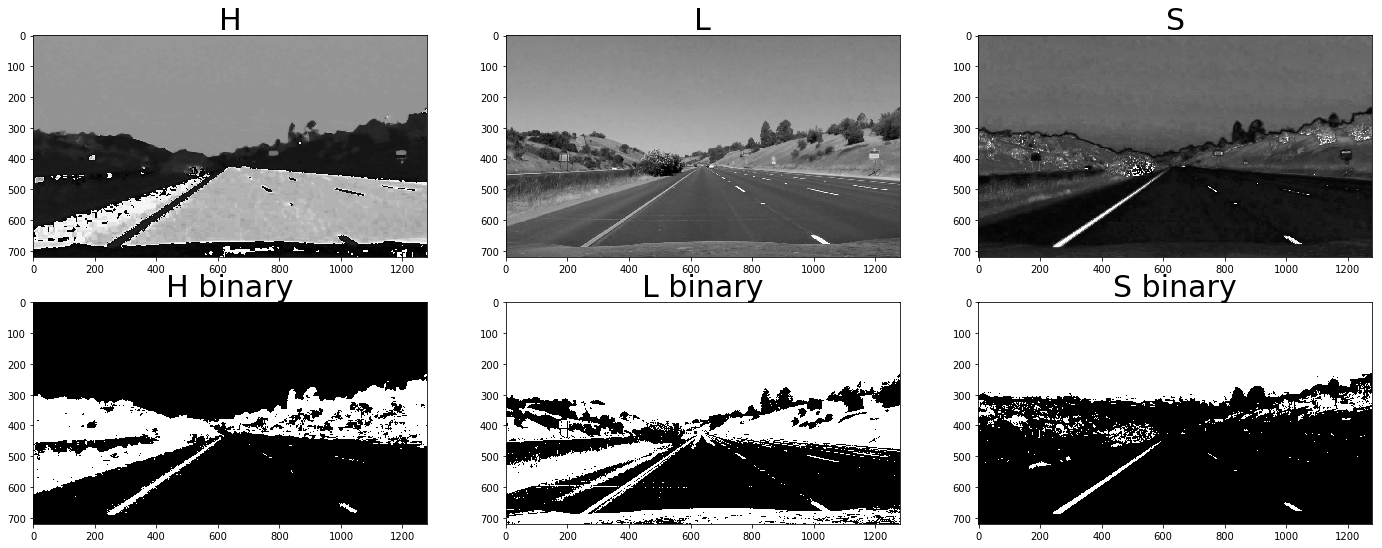

In [101]:
def hls_thresh(img, channel_number, thresh_min, thresh_max):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,channel_number]
    binary = np.zeros_like(channel)
    binary[(channel > thresh_min) & (channel <= thresh_max)] = 1
    return binary

H_binary = hls_thresh(img, 0, 15, 100)
L_binary = hls_thresh(img, 1, 90, 255)
S_binary = hls_thresh(img, 2, 90, 255)

f, axs = plt.subplots(2, 3, figsize=(24, 9))
axs[0, 0].imshow(H, cmap='gray'), axs[0, 0].set_title('H', fontsize=30)
axs[0, 1].imshow(L, cmap='gray'), axs[0, 1].set_title('L', fontsize=30)
axs[0, 2].imshow(S, cmap='gray'), axs[0, 2].set_title('S', fontsize=30)
axs[1, 0].imshow(H_binary, cmap='gray') ,axs[1, 0].set_title('H binary', fontsize=30)
axs[1, 1].imshow(L_binary, cmap='gray'), axs[1, 1].set_title('L binary', fontsize=30)
axs[1, 2].imshow(S_binary, cmap='gray'), axs[1, 2].set_title('S binary', fontsize=30)

# Color and Gradient

(<matplotlib.image.AxesImage at 0x7fbac0353f28>,
 <matplotlib.text.Text at 0x7fbac0349978>)

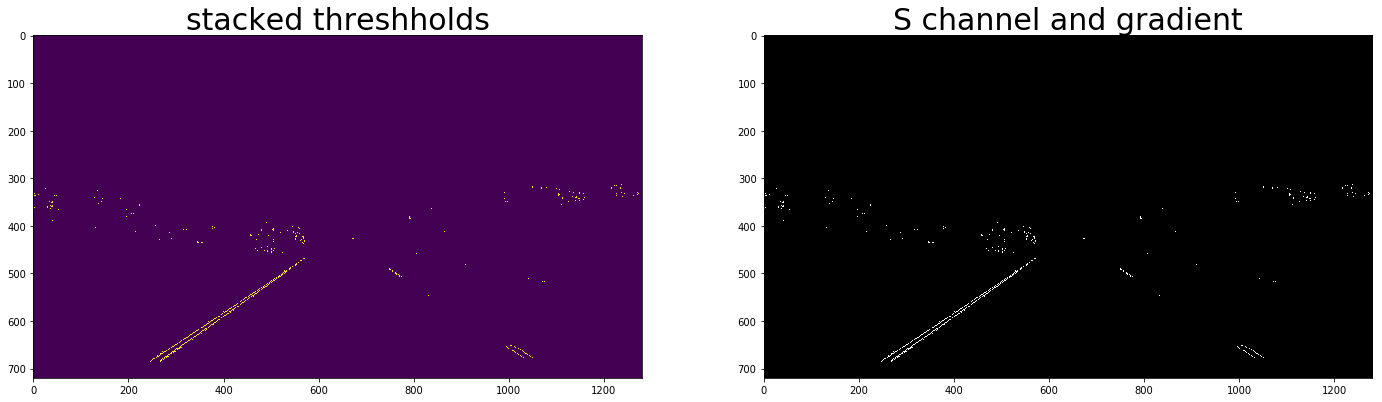

In [104]:
def combine_thresh(img):
    # img shound be undistorted
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (3, 3), 0) 
    sxbinary = abs_sobel_thresh(blur, orient='x', sobel_kernel=3, thresh_min=20, thresh_max=100)
    s_binary = hls_thresh(img, 2, 170, 255)

    # stack each channel to view theri individual contributions in green and blue respectively
    # this returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    combine_binary = np.zeros_like(sxbinary)
    combine_binary[(sxbinary == 1) & (s_binary == 1)] = 1

    return combine_binary

combine_binary = combine_thresh(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(combine_binary), ax1.set_title('stacked threshholds', fontsize=30)
ax2.imshow(combine_binary, cmap='gray'), ax2.set_title('S channel and gradient', fontsize=30)

# ROI

(<matplotlib.image.AxesImage at 0x7fbac209f9e8>,
 <matplotlib.text.Text at 0x7fbac20f9a90>)

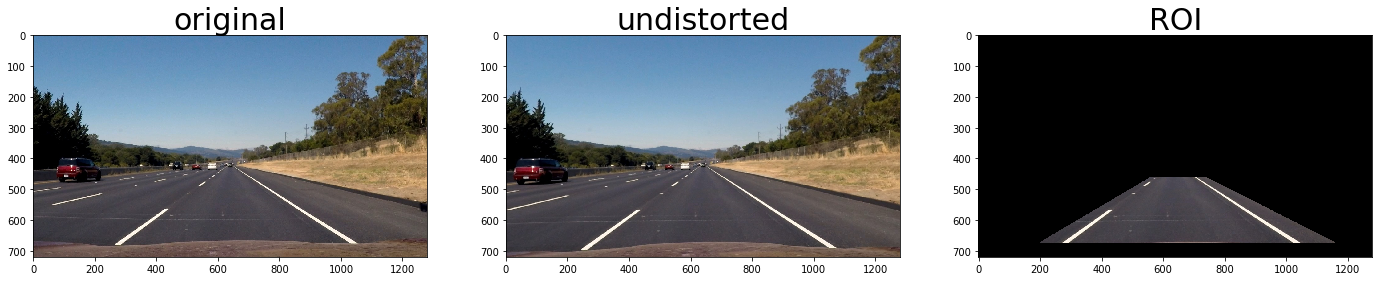

In [62]:
left_bottom = (200, 672)
left_top = (560, 460)
right_bottom = (1160, 672)
right_top = (740, 460)
roi_points = [[left_top, right_top, right_bottom, left_bottom]]

def region_of_interest(img, roi_points):
    mask = np.zeros_like(img)
    vertices = np.array(roi_points, dtype=np.int32)

    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)

    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

img = mpimg.imread("test_images/s2.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(img), axs[0].set_title('original', fontsize=30)
axs[1].imshow(undist), axs[1].set_title('undistorted', fontsize=30)
axs[2].imshow(roi), axs[2].set_title('ROI', fontsize=30)

# Warp

(<matplotlib.image.AxesImage at 0x7fbac1f65550>,
 <matplotlib.text.Text at 0x7fbac1fbf5f8>)

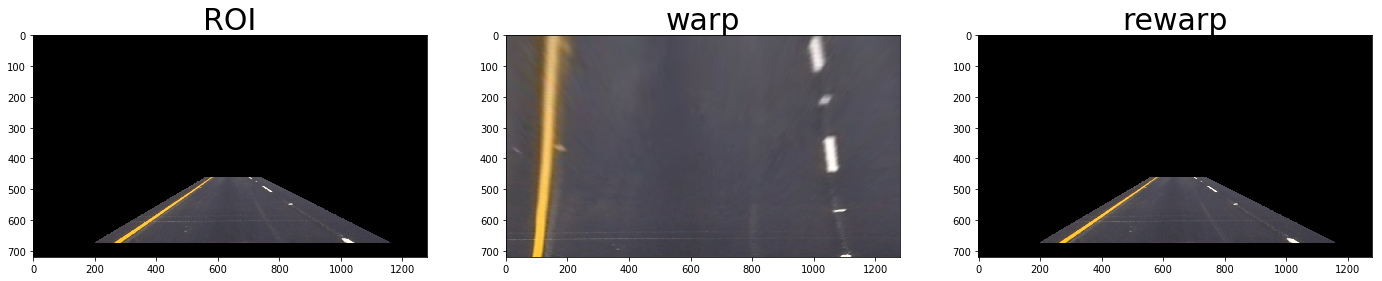

In [63]:
def warp(img, roi_points):
    src = np.float32(roi_points)
    dst = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
        
    return warped

def rewarp(img, roi_points):
    dst = np.float32(roi_points)
    src = np.float32([[0, 0], [1280, 0], [1280, 720], [0, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, (1280, 720), flags=cv2.INTER_LINEAR)
    
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
rewarped = rewarp(warped, roi_points)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(roi), axs[0].set_title('ROI', fontsize=30)
axs[1].imshow(warped), axs[1].set_title('warp', fontsize=30)
axs[2].imshow(roi), axs[2].set_title('rewarp', fontsize=30)

# Binary(ROI)

(<matplotlib.image.AxesImage at 0x7fbabba897b8>,
 <matplotlib.text.Text at 0x7fbabbae5e48>)

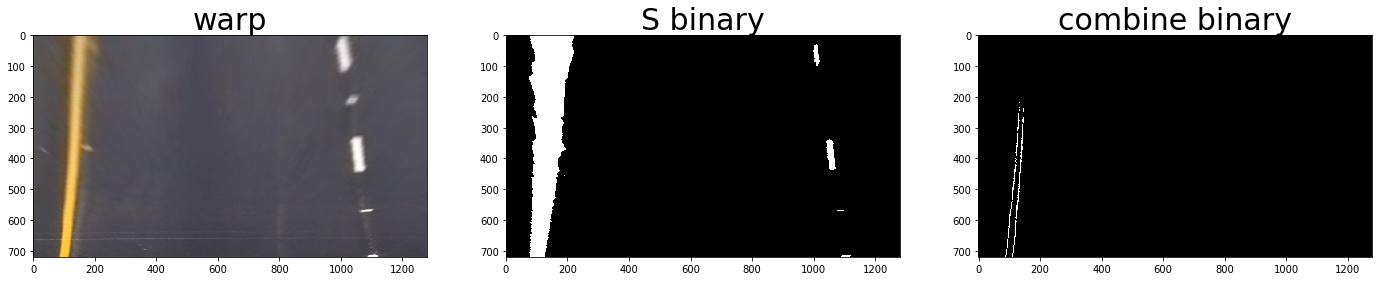

In [106]:
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
combine_binary = combine_thresh(warped)
s_binary = hls_thresh(warped, 2, 30, 255)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(warped), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(s_binary, cmap='gray'), axs[1].set_title('S binary', fontsize=30)
axs[2].imshow(combine_binary, cmap='gray'), axs[2].set_title('combine binary', fontsize=30)

# Histogram

([<matplotlib.lines.Line2D at 0x7fbac0afd358>],
 <matplotlib.text.Text at 0x7fbac0ad6390>)

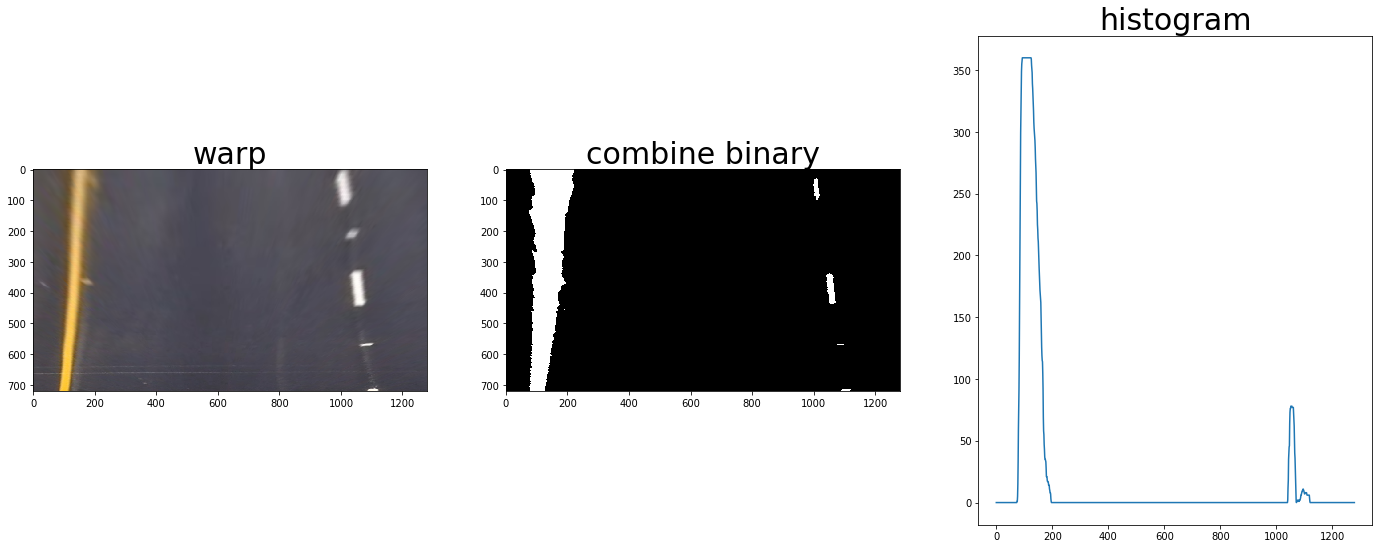

In [85]:
img = mpimg.imread("test_images/s1.jpg")
undist = cv2.undistort(img, mtx, dist, None, mtx)
roi = region_of_interest(undist, roi_points)
warped = warp(roi, roi_points)
# combine_binary = combine_thresh(warped)
s_binary = hls_thresh(warped, 2, 30, 255)
histogram = np.sum(s_binary[s_binary.shape[0]//2:,:], axis=0)

f, axs = plt.subplots(1, 3, figsize=(24, 9))
axs[0].imshow(warped), axs[0].set_title('warp', fontsize=30)
axs[1].imshow(s_binary, cmap='gray'), axs[1].set_title('combine binary', fontsize=30)
axs[2].plot(histogram), axs[2].set_title('histogram', fontsize=30)